# Critical Race Theory Tweet Sentiment Analysis

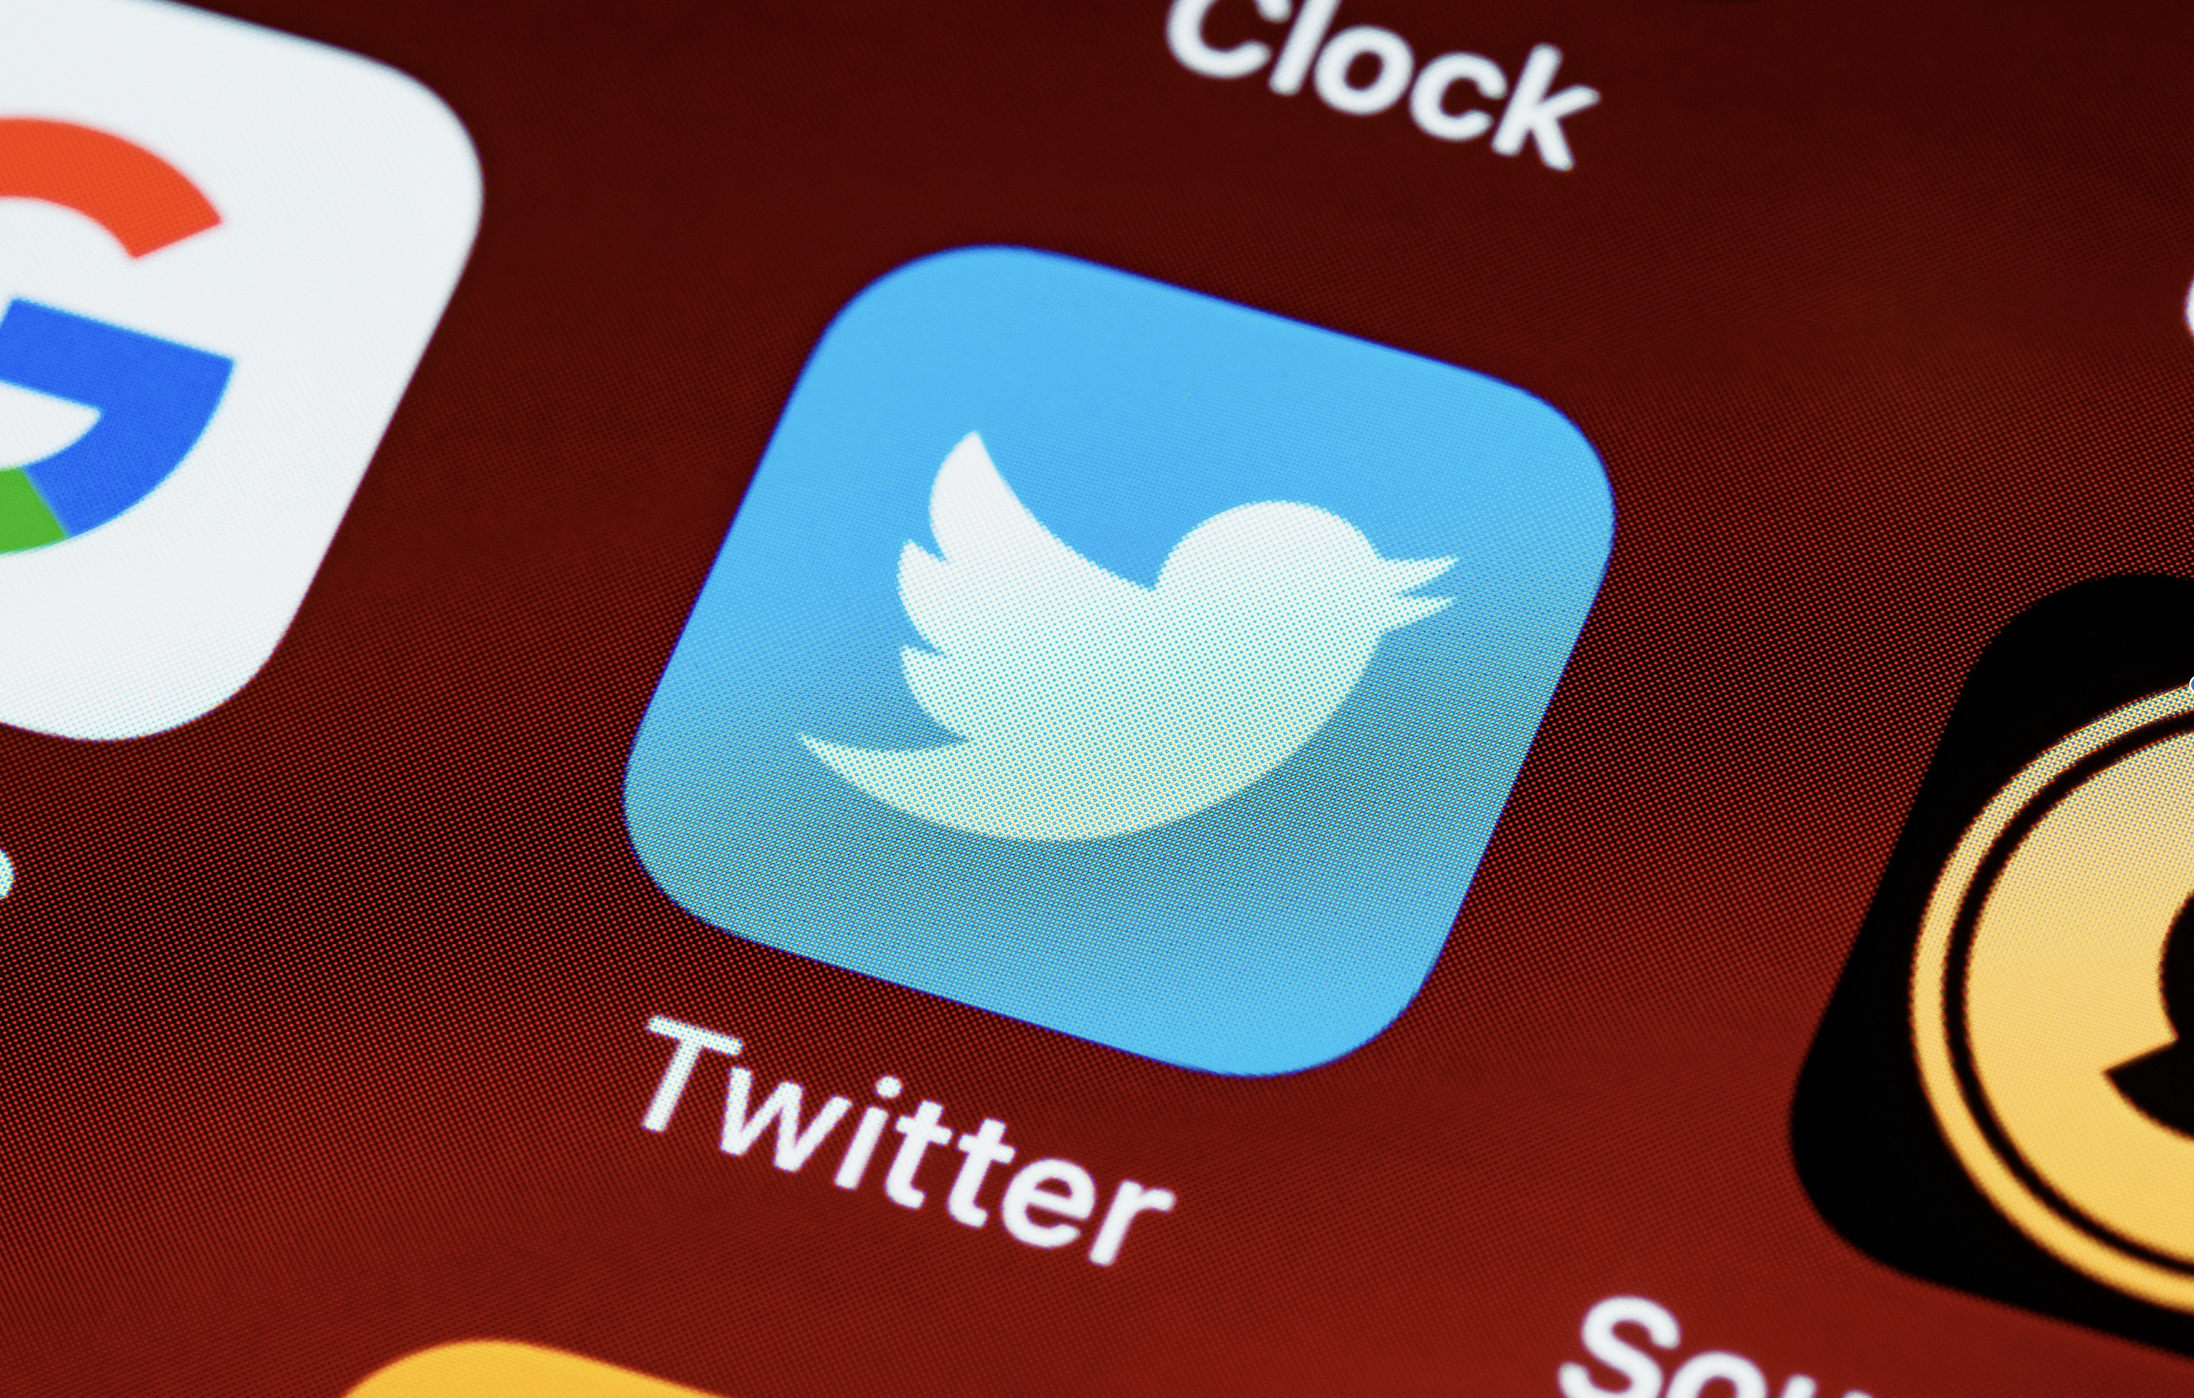

Public Relations is all about managing the reputation of clients with high public exposure, 
from mega-corps to celebrities to non-profits. What this means often, is a need to monitor 'conversation'
around certain topics concerning the client. During my time working in this field, one of the clients 
I worked with was particularly interested in the discussion around critical race theory since their 
organization was dedicated to diversity and equity within k-12 education. Before I embarked on my data
analytics education and discovered the wonders of python, we monitored social media discussion about critical 
race theory by searching through twitter and manually filtering tweets and pulling tweets. 

As language analysis becomes evermore sophisticated so do our options for 'social monitoring.' 

So I decided to recreate what I did for clients by performing sentiment analysis on tweets that I gathered
using trackmyhashtag. Ideally, I would've used 

## Import libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk
import nltk
nltk.data.path.append('/path/to/nltk_data/')
import spacy
import string
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import tqdm as notebook_tqdm

## Import Data

In [3]:
df = pd.read_csv('tweets.csv')

In [4]:
# Get the current column names
old_columns = df.columns.tolist()

# Create new column names with lowercase and underscores
new_columns = [column.lower().replace(' ', '_') for column in old_columns]

# Create a dictionary to map old column names to new column names
column_mapping = dict(zip(old_columns, new_columns))

# Rename the columns in the dataframe
df.rename(columns=column_mapping, inplace=True)

# Convert column values to lowercase
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


In [5]:
print(df.head())

                tweet_id                                          tweet_url  \
0  "1664109091411697665"  https://twitter.com/truthfullyjaine/status/166...   
1  "1664086531793993729"  https://twitter.com/leverasutton/status/166408...   
2  "1664085261045620737"  https://twitter.com/patrioticspirit/status/166...   
3  "1664083837817610243"  https://twitter.com/elharraqayoub/status/16640...   
4  "1664075889095905280"  https://twitter.com/atptatp/status/16640758890...   

      tweet_posted_time                                      tweet_content  \
0  01 jun 2023 03:18:19  "https://t.co/zsuyfcujyj\n\nnow available on i...   
1  01 jun 2023 01:48:41  "for more    https://t.co/0hbrubf3zp\n\n#1619p...   
2  01 jun 2023 01:43:38  "#lawfare #criticalracetheory #politicalpersec...   
3  01 jun 2023 01:37:58  "for more    https://t.co/0hbrubf3zp\n\n#1619p...   
4  01 jun 2023 01:06:23  "https://t.co/mlrn15me1a\n\n#professorblacktru...   

  tweet_type                 client  retweets_received  

## Pre-process text

Make all the text lower-case

In [6]:
df[df.columns[3]] = df.iloc[:, 3].str.lower()

In [7]:
print(df.head())

                tweet_id                                          tweet_url  \
0  "1664109091411697665"  https://twitter.com/truthfullyjaine/status/166...   
1  "1664086531793993729"  https://twitter.com/leverasutton/status/166408...   
2  "1664085261045620737"  https://twitter.com/patrioticspirit/status/166...   
3  "1664083837817610243"  https://twitter.com/elharraqayoub/status/16640...   
4  "1664075889095905280"  https://twitter.com/atptatp/status/16640758890...   

      tweet_posted_time                                      tweet_content  \
0  01 jun 2023 03:18:19  "https://t.co/zsuyfcujyj\n\nnow available on i...   
1  01 jun 2023 01:48:41  "for more    https://t.co/0hbrubf3zp\n\n#1619p...   
2  01 jun 2023 01:43:38  "#lawfare #criticalracetheory #politicalpersec...   
3  01 jun 2023 01:37:58  "for more    https://t.co/0hbrubf3zp\n\n#1619p...   
4  01 jun 2023 01:06:23  "https://t.co/mlrn15me1a\n\n#professorblacktru...   

  tweet_type                 client  retweets_received  

Remove urls

In [8]:
df[df.columns[3]] = df.iloc[:,3].apply(lambda x: re.sub(r'https?:\/\/\S+', '', x))
df[df.columns[3]] = df.iloc[:,3].apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))

In [9]:
print(df.head())

                tweet_id                                          tweet_url  \
0  "1664109091411697665"  https://twitter.com/truthfullyjaine/status/166...   
1  "1664086531793993729"  https://twitter.com/leverasutton/status/166408...   
2  "1664085261045620737"  https://twitter.com/patrioticspirit/status/166...   
3  "1664083837817610243"  https://twitter.com/elharraqayoub/status/16640...   
4  "1664075889095905280"  https://twitter.com/atptatp/status/16640758890...   

      tweet_posted_time                                      tweet_content  \
0  01 jun 2023 03:18:19  "\n\nnow available on iuic columbus ohio page!...   
1  01 jun 2023 01:48:41  "for more    \n\n#1619project   #reparations #...   
2  01 jun 2023 01:43:38  "#lawfare #criticalracetheory #politicalpersec...   
3  01 jun 2023 01:37:58  "for more    \n\n#1619project   #reparations #...   
4  01 jun 2023 01:06:23  "\n\n#professorblacktruth #mot #pbt #history #...   

  tweet_type                 client  retweets_received  

Replace placeholders (ex: links with {link}, videos with [video])

In [10]:
df[df.columns[3]] = df.iloc[:,3].apply(lambda x: re.sub(r'{link}', '', x))

df[df.columns[3]] = df.iloc[:,3].apply(lambda x: re.sub(r"\[video\]", '', x))

Remove HTML reference characters

In [11]:
df[df.columns[3]] = df.iloc[:,3].apply(lambda x: re.sub(r'&[a-z]+;', '', x))

Remove Non-Letter characters

In [12]:
df[df.columns[3]] = df.iloc[:,3].apply(lambda x: re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', x))

Change Twitter handles (change all the twitter handles to @mention for privacy)

In [13]:
df[df.columns[3]] = df.iloc[:,3].apply(lambda x: re.sub(r'@mention', '', x))

## Tokenize the text

#### I'm using the TweetTokenizer from NLTK to keep emojis together as a token and to keep the hashtags together


In [14]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
df['tokens'] = df.iloc[:,3]
df[df.columns[3]] = df.iloc[:,3].apply(tknzr.tokenize)

#### Now that I've tokenized everything, it’s time to remove the punctuation commonly used for emojis.First I have to create a punctuation list and then apply a filter to each tokenized list, keeping only the tokens that are not in the punctuation list. Using this method will leave all the punctuation that is part of a word or an emoji.

In [15]:
import string

PUNCTUATION_LIST = list(string.punctuation)

def remove_punctuation(word_list):
    """Remove punctuation tokens from a list of tokens"""
    return [w for w in word_list if w not in PUNCTUATION_LIST]

df['tokens'] = df['tokens'].apply(remove_punctuation)


#### Now I'll remove stopwords ( common words like "is", "and", "the", etc., beacuse they don't contribute much to my analysis).

In [16]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/josephinegreaves/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
stop_words = set(stopwords.words('english'))

In [18]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(word_list):
    """Remove stop words from a list of tokens"""
    return [w for w in word_list if w.lower() not in stop_words]

df['tokens'] = df['tokens'].apply(remove_stopwords)

## VADER Sentiment Scoring

#### I will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.


In [19]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Create an instance of the SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Analyze sentiment using the VADER lexicon
sentence = "I love using the VADER lexicon!"
sentiment_scores = analyzer.polarity_scores(sentence)

# Print the sentiment scores
print(sentiment_scores)

{'neg': 0.0, 'neu': 0.527, 'pos': 0.473, 'compound': 0.6696}


#### I imported tqdm from tqdm notebook so that I could use the progress bar tracker since I'll be using loops on this data.


In [20]:
from tqdm import tqdm
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['tweet_content']
    myid = row['tweet_id']
    res[myid] = analyzer.polarity_scores(text)

100%|██████████████████████████████████████| 100/100 [00:00<00:00, 10279.40it/s]


#### I'm creating a new DataFrame named vaders by converting the res dictionary into a DataFrame and transposing it using .T. 
#### Now I have a DataFrame with the sentiment analysis results, each tweet has its polarity score.


In [21]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'tweet_id'})
vaders = vaders.merge(df, how='left')

In [22]:
vaders.head(2)

tweet_id  neg  neu  pos  compound  \
0  "1664109091411697665"  0.0  1.0  0.0       0.0   
1  "1664086531793993729"  0.0  1.0  0.0       0.0   

                                           tweet_url     tweet_posted_time  \
0  https://twitter.com/truthfullyjaine/status/166...  01 jun 2023 03:18:19   
1  https://twitter.com/leverasutton/status/166408...  01 jun 2023 01:48:41   

                                       tweet_content tweet_type  \
0  [now, available, on, iuic, columbus, ohio, pag...    retweet   
1  [for, more, #project, #reparations, #criticalr...    retweet   

                  client  ...               user__id            name  \
0  "twitter for android"  ...  "1500123086514970631"  "truthfulness"   
1  "twitter for android"  ...             "43336894"        "levera"   

          username                                           user_bio  \
0  truthfullyjaine  "the fact of being true; truth.\n\nyour fault ...   
1     leverasutton                                                 ""   

  verified_or_non-verified                          profile_url  \
0             non-verified  https://twitter.com/truthfullyjaine   
1             non-verified     https://twitter.com/leverasutton   

  user_followers user_following user_account_creation_date  \
0             24            121       05-mar-2022 14:56:47   
1            556           2177       29-may-2009 14:16:01   

                                              tokens  
0  [\n, \n, n, w,  , v, l, b, l, e,  , n,  , u, c...  
1  [f, r,  , r, e,  ,  ,  ,  , \n, \n, p, r, j, e...  

[2 rows x 24 columns]

## Plot VADER results

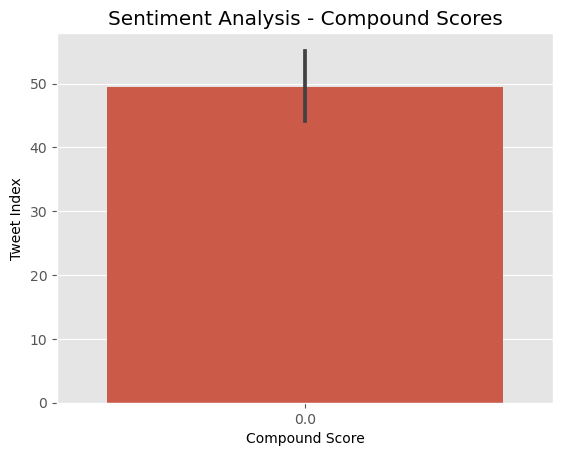

In [23]:
sns.barplot(x=vaders['compound'], y=vaders.index)
plt.xlabel('Compound Score')
plt.ylabel('Tweet Index')
plt.title('Sentiment Analysis - Compound Scores')
plt.show()

In [24]:
# Filter the DataFrame to exclude rows with a value of 0.0
filtered_vaders = vaders[(vaders['neg'] != 0.0) | (vaders['neu'] != 0.0) | (vaders['pos'] != 0.0)]

# Get the count of each sentiment category
sentiment_counts = filtered_vaders[['neg', 'neu', 'pos']].astype(bool).sum()

# Print the count of non-zero negative, neutral, and positive entries
print("Non-zero negative entries:", sentiment_counts['neg'])
print("Non-zero neutral entries:", sentiment_counts['neu'])
print("Non-zero positive entries:", sentiment_counts['pos'])

Non-zero negative entries: 0
Non-zero neutral entries: 100
Non-zero positive entries: 0


### In conclusion: All of the 101 tweets in this sample are neutral.

# Roberta Pretrained Model

#### Now I'm going to run the RoBERTA model on the tweets and then compare            the results to VADER

#### - Roberta handles context better
#### - It can also handle domain-specific expressions


In [44]:
import torch
from transformers import AutoTokenizer
from scipy.special import softmax
from transformers import RobertaTokenizer, RobertaForSequenceClassification

#### Now I'm gonna pull in a model that has been pre-trained on a lot of dat for sentiment

In [67]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [52]:
example = df['tweet_content'][50]
print(example)

['my', "bf's", 'mother', 'avid', 'fox', 'news', 'watcher', 'told', 'him', 'she', 'recalled', 'him', 'telling', 'her', 'that', 'he', 'learned', '#criticalracetheory', 'in', 'college', 'um', 'he', 'was', 'a', 'business', 'majorin', 'the', 's', 'we', 'only', 'heard', 'about', 'crt', 'like', 'years', 'ago', 'when', 'republicans', 'made', 'it', 'their', 'new', 'boogeyman', 'fox', 'news', 'rots', 'your', 'brain']


In [66]:
def polarity_scores_roberta(text):
    encoded_text = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    output = model(**encoded_text)
    scores = output.logits.detach().numpy()
    scores_dict = {
        'roberta_neg': scores[0][0],
        'roberta_neu': scores[0][1],
        'roberta_pos': scores[0][2]
    }
    return scores_dict

res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['tweet_content']
        myid = row['tweet_id']
        vader_result = analyzer.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'tweet_id'})
results_df = results_df.merge(df, how='left')

100%|█████████████████████████████████████████| 100/100 [00:10<00:00,  9.39it/s]


In [68]:
roberta_scores = results_df[['roberta_neg', 'roberta_neu', 'roberta_pos']]

In [69]:
correlation_matrix = roberta_scores.corr()

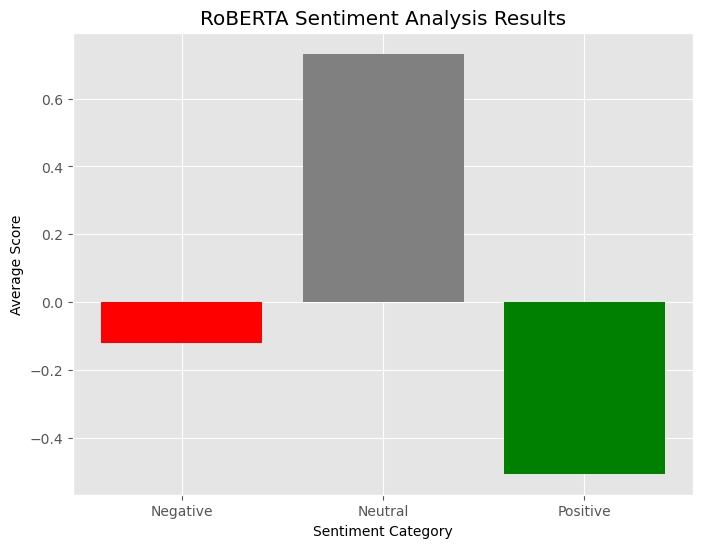

In [71]:
# Select the sentiment score columns
sentiment_scores = results_df[['roberta_neg', 'roberta_neu', 'roberta_pos']]

# Calculate the average sentiment scores
average_scores = sentiment_scores.mean()

# Define the sentiment categories and their corresponding average scores
sentiment_categories = ['Negative', 'Neutral', 'Positive']
scores = average_scores.values

# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(sentiment_categories, scores, color=['red', 'grey', 'green'])
plt.xlabel('Sentiment Category')
plt.ylabel('Average Score')
plt.title('RoBERTA Sentiment Analysis Results')
plt.show()

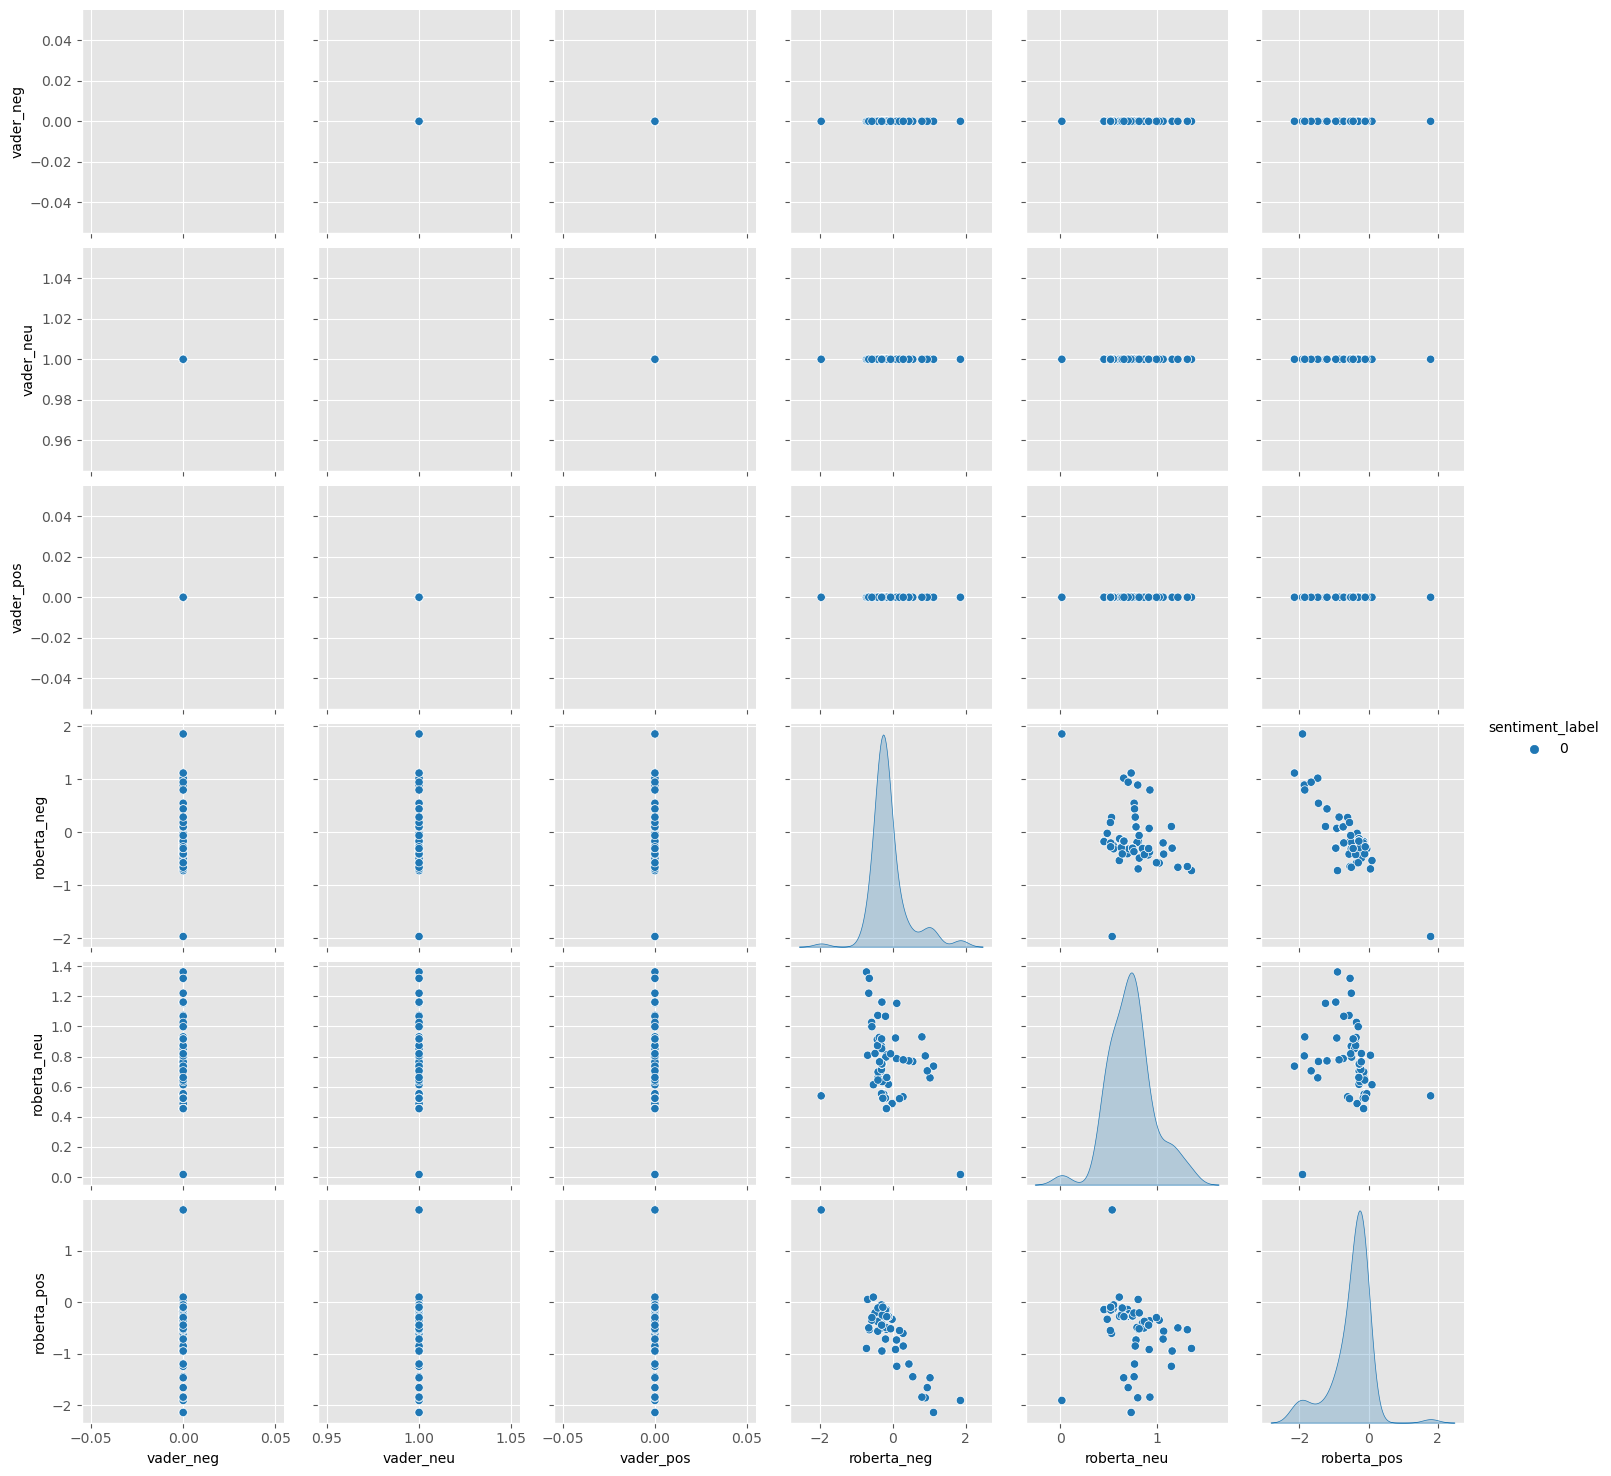

In [65]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='sentiment_label',
            palette='tab10')
plt.show()

Comparitively, RoBERTA was much more confident than VADER. According to the results of the RoBERTA analysis, and overwhelming majority of the tweets were neutral